<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/homework/hw3/GM/Tema_3_Neural_Style_Transfer_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 3 - A new Picasso is in town
## Neural Style Transfer
### Autori: 
* George Muraru

## 1. Scopul temei


Tema are ca scop folosirea rețelelor neurale convoluționale pentru a **modifica imagini prin preluarea stilului** de la o alta imagine.
Este o tehnica prin care se genereaza o noua imaginie folosind o imagine de baza (eng. *content image*) și o imagine a cărui stil (eng. *style image*) dorim să îl transferăm la imaginea de bază (rezultat numit în temă *generated image*). 


![result](https://raw.githubusercontent.com/cs-pub-ro/ML/master/homework/hw3/GM/img/colab/result.svg)



### 2. High Level Architecture

<img src="https://miro.medium.com/max/1294/1*ZgW520SZr1QkGoFd3xqYMw.jpeg" alt="High Level Architecture" width=1250/>

Reference: [Intuitive guide to neural style transfer](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee)
 

### Descărcare bibloteci/fișiere de care vom avea nevoie

In [8]:
!pip install torch
!pip install torchvision
!pip install pillow

!wget -q -O starry_night.jpg "https://github.com/cs-pub-ro/ML/blob/master/homework/hw3/GM/img/style/starry_night.jpg?raw=true"
!wget -q -O cat.png "https://github.com/cs-pub-ro/ML/blob/master/homework/hw3/GM/img/content/cat.png?raw=true"

### Biblioteci de care vom avea nevoie

In [0]:
import torch
import torch.optim as optim
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt

### Hiper-parametrii



In [0]:
CUDA = True #@param {type: "boolean"}
ALPHA = 333 #@param {type: "slider", min: 0, max: 1e5, step: 1}
BETA = 1e3 #@param {type: "slider", min: 0, max: 1e5, step: 1}
IMG_SIZE = 512 #@param [128, 256, 512]

### Model

Pentru a putea extrage **stilul** și **conținutul** unei imagini ne vom folosi de o rețea neurală deja antrenată.

Noțiunea de a folosi o rețea pre-antrenată pentru a rezolva un alt task poartă denumirea de [Transfer Learning](https://ruder.io/transfer-learning/).

Într-o rețea convoluțională primele layere extrag feature-uri low-level (acestea le vom folosi să extragem **stilul**), iar layerele "mai apropiate de output" ne vor furniza **conținutul**.

Pentru acest lucru vom folosi o rețea VGGNet, mai specific VGG19.

![VGG19](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

Parametrii rețelei vor trebui să ramână fixați la valorile inițiale pe parcursul rulării. Din acest motiv va trebui să nu facem update parametrilor în timpul optimizării.

Din rețeaua mai sus specificată vom folosi anumite layere (descrise mai jos) pentru a extrage feature-urile care ne interesează pentru cele 2 loss-uri.

In [11]:
# TODO 1.0: Load model and move it to CUDA if selected
vgg19 = models.vgg19(pretrained=True, progress=False)
if CUDA:
  vgg19 = vgg19.cuda()
# TODO 1.1: Freeze the parameters for the model
for param in vgg19.parameters():
    param.requires_grad = False
print(len(vgg19.features))
print(vgg19.features)
# print(vgg19.features[21])

37
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): Max

### Imagini folosite

Problema pe care dorim să o rezolvăm este de a genera **conținut** apropiat de o imagine de referință, conținut al cărui **stil** trebuie să fie apropiat de o altă imaginie.

Pentru acest lucru ne vom defini 3 imagini:
1. Imaginea a cărui conținut dorim să il copiem - notată $I_{C}$
2. Imaginea a cărui stil dorim să îl copiem - notată $I_{S}$
3. Imaginea generată (aceasta va avea inițial valori generate random) - notată $I_{G}$
  * această imagine va fi modificată în timpul optimizării

Intuitiv, soluția ar trebui să presupună rezolvarea a 2 probleme separate:
* Generare de **conținut**
* Generare de **stil**

Pentru a cunatifica cât de aproape suntem de o soluție (o imaginie generată perfect) vom folosi 2 loss-uri, specificate în continuare.

### Lucrul cu imagini

Un prim pas care trebuie realizat este deschiderea și afișarea unei imagini.
Ar trebui ca să avem 2 imagini descărcate: *starry_night.jpeg* și *cat.png*.

De asemnea, deoarece folosim o rețea neurală predefinită, va trebui să modificăm inputul astfel încât acesta să corespundă inputului așteptat de către rețea.



In [0]:
def get_image(img_path):
    """ Get an image ready to be run through the pretrained neural network

    Args:
        img_path (string): the path to the image

    Returns:
        A tensor with shape (B, H, W, C) where:
        * B - represents the batch size (SHOULD BE 1)
        * C - number of channels (3 - RGB)
        * H - the height of the image (it should be IMG_SIZE after transformation)
        * W - the width of the image (it should be IMG_SIZE after transformation)
    """
    img = Image.open(img_path).convert('RGB')

    '''
        TODO 1.0 - Use the transforms from torch library to do the following ops:
        * Resize to an image of (IMG_SIZE, IMG_SIZE)
        * Transform to a tensor (since the PIL library works with numpy arrays)
        * The tensor should have values in the range [0, 1]
        * Normalize using :
            * mean = [0.485, 0.456, 0.406]
            * std = [0.229, 0.224, 0.225]
            (because the pretrained model was trained using those values)
            (Formula: new_img = (img - mean) / std)
    '''

#     print(str(img_path) + ": " + str(img.size) + "-" + str(type(img)))
    img_r = transforms.functional.resize(img, (IMG_SIZE, IMG_SIZE))
#     print(str(img_path) + ": " + str(img_r.size) + "-" + str(type(img_r)))
    tens = transforms.functional.to_tensor(img_r)
#     print(str(img_path) + ": " + str(tens.shape) + "-" + str(type(tens)))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    new_tens = transforms.functional.normalize(tens, mean, std)
#     print(new_tens)
    
    # TODO 1.1: Add a size 1 dimension for the batch
    # Hint: unsqueeze
    tens = torch.unsqueeze(new_tens, 0)
#     print(str(img_path) + ": " + str(tens.shape) + "-" + str(type(tens)))
    
    # TODO 1.2: Move to cuda if support is enabled

    if CUDA:
      return tens.cuda()

    return tens


def show_imgs(*imgs):
    """ Plot images received as parameters (on the same row with different
        collumn)

    Args:
        imgs (tensors representing the images): images to plot
    """
    plt.figure(figsize=(15,15))

    # TODO 2.0:
    # Define the inverse of the `normalize` and `toTensor` operations performed
    # in the `get_image` function
    
    def de_normalize(tensor):
        for t, m, s in zip(tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
                t.mul_(s).add_(m)
        return tensor
    def to_img(tensor):
        return transforms.functional.to_pil_image(tensor)

    for i, img in enumerate(imgs):

        # TODO 2.1: Detach, clone and move to CPU (the image)
        img = img.detach().clone().cpu()
        # TODO 2.2: Remove the `batch` dimension (the first one)
        # Hint: squeeze
        
#         print(img.shape)
        img_r = torch.squeeze(img, 0)
#         print("reshaped to: " + str(img_r.shape))
        
        # TODO 2.3: Apply the inverse of the `normalize` operation
        img = de_normalize(img_r)
        plt.subplot(1, 2, i+1)

        # Remove the x, y coordinates from the plot and show the image
        img = to_img(img)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
    plt.show()

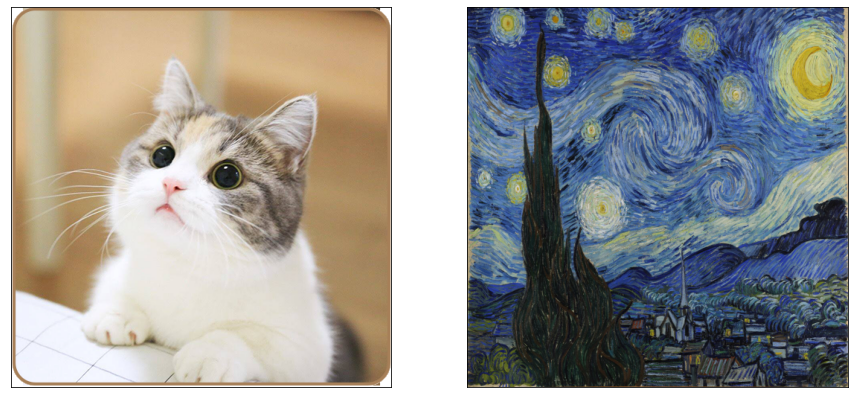

In [13]:
# Testing Area
img_cat = get_image("cat.png")
img_starry_night = get_image("starry_night.jpg")

assert isinstance(img_cat, torch.Tensor)
assert img_cat.shape == (1, 3, IMG_SIZE, IMG_SIZE)
assert not CUDA ^ img_cat.is_cuda

show_imgs(img_cat, img_starry_night)

### Content Loss

Loss-ul aceasta are rolul de a ne ajuta să recreăm **conținutul** unei imagini, el însemnând cât de mult diferă imaginea generată față de imaginea al cârui conținut dorim să îl "copiem".

După cum s-a menționat mai sus, activările (eng. activation map/feature map) straturilor convoluționale aflate spre finalul rețelei ne oferă informații mai high-level despre o imagine.

Putem folosi aceste activări pentru a calcula **content loss**:

$$
J_{content} = \frac{1}{N}\sum_{i,j}(a_{generated}^{i,j} - a_{content}^{i,j})^2
$$

Unde:
* $N$ - numărul de elemente din feature map-ul specific
* $a_{generate}$ - matricea activărilor specifice $I_{G}$
* $a_{content}$ - matricea activărilor specifice $I_{C}$

Pentru a obține feature map-ul se va face un **feedforward** cu imaginile:
* $I_{G}$ pentru a obține $a_{generated}$
* $I_{C}$ pentru a obține $a_{content}$

Stratul de convoluție a carui activări ne interesează este **conv4_2** (21) (vedeți imaginea de mai sus de la VGG19).

In [14]:
def run_feedforward(img, model):
    ''' Do a feedforward step using the image given as parameter and keep track
    of the activations

    Args:
        img (Tensor): the image used for feedforward
        model (Model): the pretrained (and frozen) model

    Returns:
        A list containing the activations generated by passing the image through
    the model
    '''
    activations = []
    
    # TODO 3.0: Compute the activations (for each layer of the model) and
    # store them in the list
    for feature in model.features:
#         print(str(i) + " " + str(model.features[i]))
        ## poate trebuie append aici
        img = feature.forward(img)
        activations.append(img)

    return activations
x = run_feedforward(img_cat, vgg19)
# print(type(x))
# print(type(x[0]))
# for i in x:
#     print(i.shape)


def get_content_loss(features_content, features_generated):
    ''' Get the Content Loss

    Args:
        features_content ([Tensor]): the activations for I_C
        features_generatd ([Tensor]): the activations for I_G
    Returns:
        loss (double) - the computed loss for the content
    '''
    # TODO 4.0: Compute the content lost
#     print(features_content[21].shape)
#     print(features_generated[21].shape)
    N = 1
    for el in features_content[32].shape:
        N = N * el
    loss = torch.mean((features_generated[32]-features_content[32])**2)
#     print(type(loss))
#     print(loss.shape)
#     loss = 0.0

    return loss
get_content_loss(x, x)

tensor(0., device='cuda:0')

### Style Loss



#### **Gram Matrix (Style Matrix)**




Pentru a calcula *style loss-ul* va trebui să folosim *matricea Gram*, calculată pe activările anumitor straturi convoluționale.

Matricea Gram a unui set de vectori V = $(v_0, v_1, v_2,...,v_n)$ este dată de produsul matriceal dintre $V și V^t$.

Această matrice are rolul de a indica care set de feature-uri sunt corelate au valori mari împreună/sunt similare.

Mai multe detalii puteți găsi [aici](https://arxiv.org/pdf/1606.01286.pdf)


#### **Calcul Style Loss**

Style loss-ul va fi reprezentat de *distanța* între matricea gram specifică activărilor pentru imaginea $I_{G}$ și pentru imaginea $I_{S}$.

Pentru activările unui specific layer convoluțional, formula de calcul este următoarea:
$$
    J_{style}^{l} = \frac{1}{4N^2}\sum_{i,j}(G^{i,j}(a_{generated}) - G^{i,j}(a_{style}))^2
$$

Unde:
* l - layer-ul convoluțional pentru care se calculează loss-ul
* $N$ - numărul de elemente din feature map-ul specific
* $a_{generate}$ - matricea activărilor specifice $I_{G}$
* $a_{style}$ - matricea activărilor specifice $I_{style}$

Pentru a obține feature map-ul se va face un **feedforward** cu imaginile:
* $I_{G}$ pentru a obține $a_{generated}$
* $I_{S}$ pentru a obține $a_{style}$

Deoarece activările pentru $I_{G}$ au fost deja calculate de la pasul de *Contnt Loss* acestea **nu vor mai fi recalulate la acest pas**.

Dacă pentru calcularae *content loss-ului* am folosit un singur strat de convoluție, pentru a *captura* stilul unei imagini, vom folosi **mai multe straturi din rețeaua VGG19**, fiecare strat având o anumită pondere la *style loss-ul* final (vedeți cerința de mai jos).

In [0]:
def get_gram_matrix(X):
    ''' Compute the Gram Matrix for the tensor X (the activation map)
    
    Args:
        X (Tensor): Tensor with shape (B, F, H, W)
    
    Returns:
        Tensor representing the Gram Matrix
    '''
    g = None
    _, c, h, w = X.shape

    # TODO 5.0: `g` should be a matrix where:
    # * the rows -- nr of channels
    # * the columns -- elements for that specific channel
    # X_new = ...
    X_new = X.view(c, h*w)
    g = torch.mm(X_new, X_new.t())
    
    return g

g = get_gram_matrix(x[21])
# print(type(g))
# print(g.shape)

def get_style_loss(features_style, features_generated):
    ''' Get the Style Loss

    Args:
        features_style ([Tensor]): the activations for I_S
        features_generatd ([Tensor]): the activations for I_G
    Returns:
        loss (double) - the computed loss for the content
    '''
    
    layers = [0, 2, 10, 12]
    # TODO 5.1 Compute style loss
    loss = 0.0
    w = 0.2
    
    for layer in layers:
#         print(str(layer) + ": " + str(vgg19.features[layer]))
        feature = features_generated[layer]
        _, c, h, w = feature.shape
        
        g_style = get_gram_matrix(features_style[layer])
        g_generated = get_gram_matrix(features_generated[layer])
    
        layer_loss = torch.mean((g_generated - g_style)**2)/(c*h*w*4)
        loss = loss + w*(layer_loss)
    return loss
l = get_style_loss(x, x)
# print(l)

### Generare imagine

Se vor folosi loss-urile definite anterior pentru a calcula un loss total și pentru a genera imaginea finală.

Style Loss: 0.9460968375205994 Content Loss: 0.9269892573356628


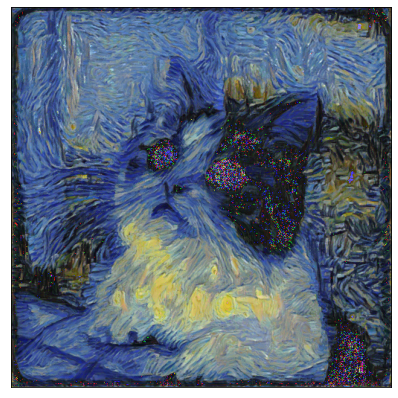

Style Loss: 0.13201643526554108 Content Loss: 0.5827822089195251


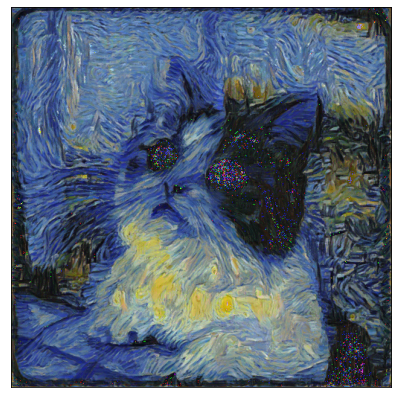

Style Loss: 0.04956081882119179 Content Loss: 0.47139060497283936


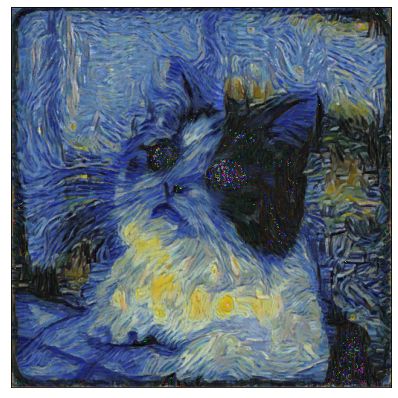

Style Loss: 0.027285758405923843 Content Loss: 0.40480196475982666


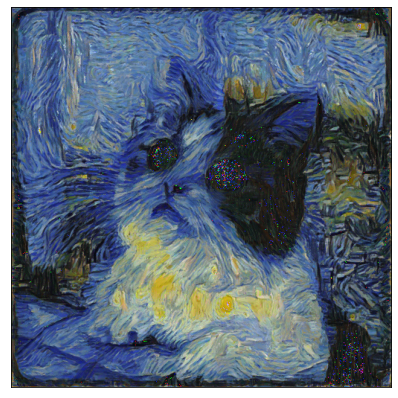

Style Loss: 0.01824086159467697 Content Loss: 0.35820960998535156


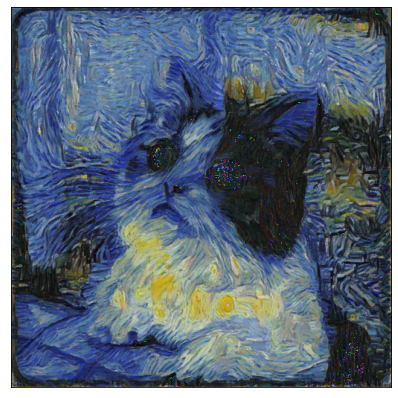

Style Loss: 0.013196788728237152 Content Loss: 0.325560063123703


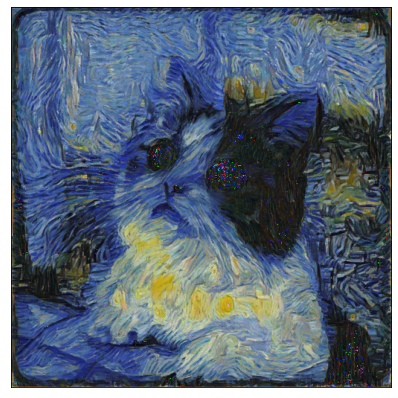

Style Loss: 0.010166194289922714 Content Loss: 0.3026903569698334


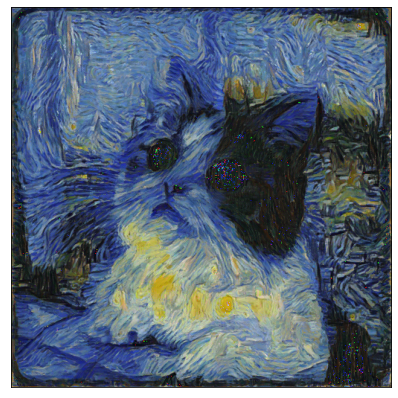

Style Loss: 0.008295702748000622 Content Loss: 0.28470322489738464


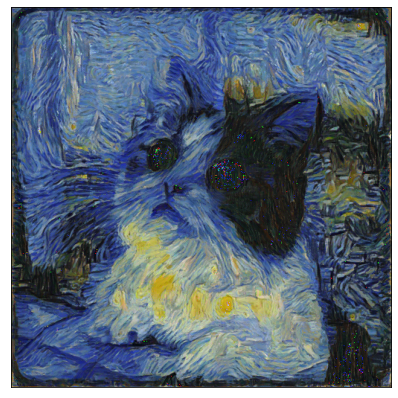

Style Loss: 0.007005980703979731 Content Loss: 0.26947537064552307


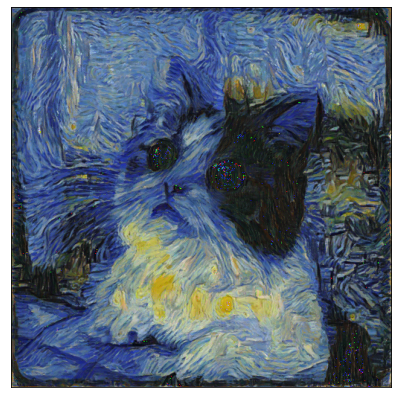

Style Loss: 0.0060770027339458466 Content Loss: 0.25681352615356445


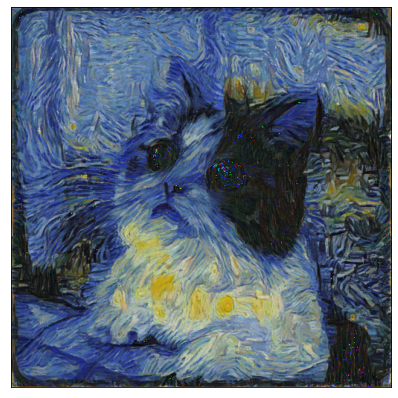

Style Loss: 0.0053686341270804405 Content Loss: 0.24590715765953064


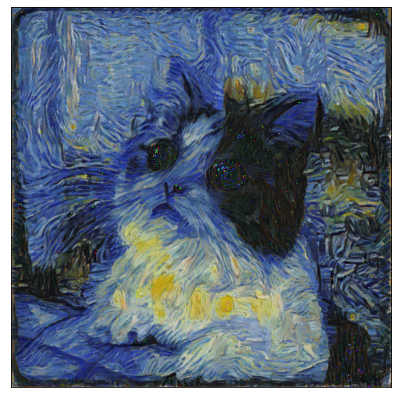

Style Loss: 0.004817586857825518 Content Loss: 0.23620513081550598


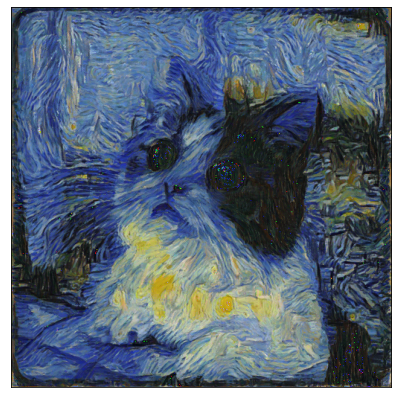

Style Loss: 0.004364101216197014 Content Loss: 0.22742566466331482


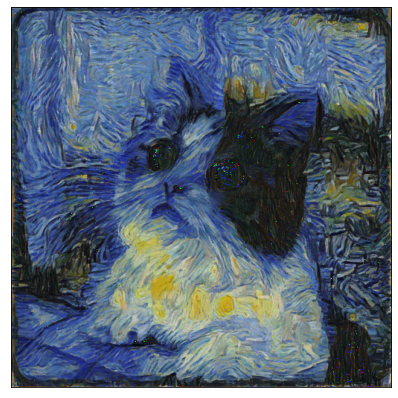

Style Loss: 0.004012683872133493 Content Loss: 0.2196066677570343


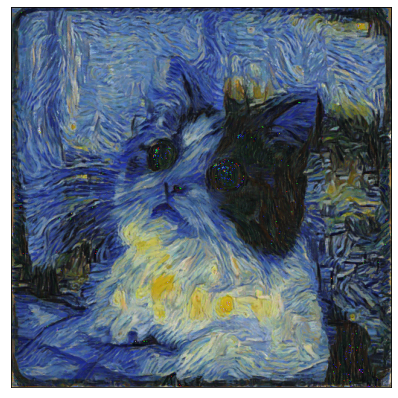

KeyboardInterrupt: ignored

In [19]:
content_img = get_image("cat.png")
style_img = get_image("starry_night.jpg")

steps = 10000

generated_img = content_img.clone()

# Need to be set since this image will be updated using the optimizer
generated_img.requires_grad = True

# TODO 6.0: Get content and style features
a_content = run_feedforward(content_img, vgg19)
a_style = run_feedforward(style_img, vgg19)

optimizer = optim.LBFGS([generated_img.requires_grad_()])

it = [0]
for i in range(1, steps+1):
    def closure():
            optimizer.zero_grad()

            # TODO 6.1: Run feedforward for the generated_img
            a_generated = run_feedforward(generated_img, vgg19) 

            # TODO 6.2: Compute content loss
            content_loss = get_content_loss(a_content, a_generated) 
            
            # TODO 6.3: Compute style loss
            style_loss = get_style_loss(a_style, a_generated)

            loss = ALPHA * content_loss + BETA * style_loss
            loss.backward()

            it[0] += 1
            if it[0] % 500 == 0:
                print(f'Style Loss: {style_loss} Content Loss: {content_loss}')
                show_imgs(generated_img)

            return loss

    optimizer.step(closure)

### Cerințe


1. [0.5pct] Încărcați modelul pre-antrenat VGG19, mutați-l pe CUDA (daca există suport) și faceți ca antrenarea să nu modifice parametrii modelului.

2. [2pct] Scrieți codul necesar pentru a încarca o imagine și a o pregăti pentru a putea fi trimisă la rețeaua anterior încarcată.

    Mutați datele pe CUDA (daca există suport).

    Convertiți imaginea în formatul inițial pentru a putea fi afișată.


3. [1pct] Implementați funcția *run_feedforward* care trebuie să facă o trecere a datelor prin rețea.

4. [1pct] Calculați *Content Loss*.
   
   Folosiți layerul e convoluție: **conv4_2** pentru a extrage activarea necesară.

4. [2pct] Calculați *Style Loss*.
   
   Folosiți layerele următoare pentru a extrage *style loss-ul*: **conv1_1, conv2_1, conv3_1, conv4_1, conv5_1**.

    Fiecare strat va avea o pondere de 0.2.
$$
    J_{style} = \sum_{i}w_i  J_{style}^{i}
$$

5. [2.5pct] Completați codul necesar pentru a genera imaginea finală.
   
   Vedeți ce se întâmplă când modificați parametrul ALPHA, BETA, ponderile de la *Style Loss* pentru fiecare strat, straturile folosite pentru extragerea *stilului* și a *conținutului*.

    De asemenea, se poate experimenta și cu inițializarea $I_{G}$ cu valori random.

6. [1pct] Rulați programul pentru alte 3-4 perechi de imagini.

7. [Bonus - 2pct] Încercați să îmbunătățiți calitatea imaginii finale.

    Posibile metode: adaugare loss adițional, calculat loss-urile folosind o altă formulă, schimbare rețea, etc.
    Pentru aceasta trebuie să aveți în notebook o poză generată folosind metoda inițială și o altă poză cu noua metodă.

**Atenție**: Este în regulă dacă pozele generate conțin artefacte! De asemenea, anumiți parametrii funcționeaza mai bine pentru diferite poze.